# Práctica Final del módulo de Machine Learning
##### Amparo Alías Cuesta
**------------------------------------------------------------------------------------------------------------------**

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')
import pickle

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
from datetime import datetime
import time

In [3]:
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import SVR

In [4]:
import os 
path = os.path.dirname(os.path.realpath('PracticaFinal_AmparoAlias')) 
print(path)
import sys 
sys.path.insert (0, path) 

/Users/amparoalias/Desktop/Keepcoding/MachineLearning


In [5]:
import utils 
from utils import proces_data

## Read data

In [6]:
#full_df = pd.read_csv('airbnb-listings.csv', sep=';', decimal='.')
#print(f'Dimensiones del dataset completo: {full_df.shape}')

## Divide into train/test

In [7]:
#train, test = train_test_split(full_df, test_size=0.2, shuffle=True, random_state=0)
#print(f'Dimensiones del dataset de training: {train.shape}')
#print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
#train.to_csv('./train.csv', sep=';', decimal='.', index=False)
#test.to_csv('./test.csv', sep=';', decimal='.', index=False)

## Training data ready

In [8]:
train_data = pd.read_csv('./train.csv', sep=';', decimal='.')
train_data,mean_map = proces_data(train_data,'train')

In [9]:
train_data.shape

(9185, 28)

In [10]:
objective_var = 'Price'

y_train = train_data[objective_var].values

df = train_data.drop(objective_var, axis = 1)
X_train = df.values 

feature_names = set(train_data.columns) - set(objective_var)

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Data ready to evaluate the model

In [11]:
test_data = pd.read_csv('./test.csv', sep=';', decimal='.')
test_data = proces_data(test_data,'test',mean_map)
test_data.shape

(2305, 28)

In [12]:
objective_var = 'Price'

y_test = test_data[objective_var].values

df = test_data.drop(objective_var, axis = 1)
X_test = df.values 

feature_names = set(test_data.columns) - set(objective_var)

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
X_test = scaler.transform(X_test) 

## Train the models

### SVR

Don't run the following two cells, just load the already trained model.

--------------------------------------------------------

In [64]:
start_time = time.time()

vectorC = np.logspace(2, 5, 10)
vectorG = np.logspace(-5, 1, 8)

param_grid = {'C': vectorC, 'gamma':vectorG}
grid = RandomizedSearchCV(SVR(kernel='rbf'), param_distributions=param_grid, cv = 5, verbose=1)
grid.fit(XtrainScaled, y_train)

end_time = time.time()

print(f"--- Time spent = {(end_time - start_time)/60} minutes ---")

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 143.3min finished


--- Time spent = 143.63372608423234 minutes ---


In [67]:
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.683
best parameters: {'gamma': 0.026826957952797246, 'C': 215.44346900318845}


#### Save and load the model:

In [14]:
filename = 'models/svr_model'
#pickle.dump(grid, open(filename, 'wb'))

--------------------------------------------------------

In [13]:
# load the model from disk
filename = 'models/svr_model'
svr = pickle.load(open(filename, 'rb'))

#### Evaluate the model

In [14]:
result = svr.score(X_test, y_test)
print(result)

0.7132016268962897


### Random Forest

best mean cross-validation score: 0.722
best parameters: {'max_depth': 14}


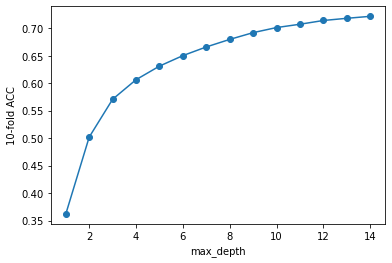

In [40]:
# grid search
maxDepth = range(1,15)
tuned_parameters = {'max_depth': maxDepth}

grid = GridSearchCV(RandomForestRegressor(random_state=0, n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=10) 
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')

plt.show()


In [42]:
# Tu código aquí
maxDepthOptimo = 10#grid.best_params_['max_depth']
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))

Train:  0.7971255929446992


#### Save and load the model:

In [51]:
#Save the model:
filename = 'models/rf'
pickle.dump(bagModel, open(filename, 'wb'))

In [15]:
#Load the model:
filename = 'models/rf'
bagModel = pickle.load(open(filename, 'rb'))

#### Evaluate the model:

In [16]:
print("Test: ",bagModel.score(X_test,y_test))

Test:  0.7208740132517883


## Conclusiones

Vemos que el modelo de regresión para predecir los precios de los apartamentos de airbnb que mejor funciona es el **RandomForest**, con una accuracy sobre test del 72%. <br>Además, es mucho más rápido ya que apenas tarda 15 minutos, mientras que SVR tarda sobre 2 horas y media. 

Todo el procesamiento de la data está basado en los datos de train y justificados en el notebook **DataProcessing**